In [6]:
from pylab import *
import matplotlib.animation as animation 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import *
from scipy.integrate import quad
from qutip import *
from qutip.qip.operations import rx
from qutip.qip.circuit import QubitCircuit

# Single qubit gate on a Qutrit

Information about the pulse can be found here
https://static-content.springer.com/esm/art%3A10.1038%2Fs41534-019-0185-4/MediaObjects/41534_2019_185_MOESM1_ESM.pdf

In [177]:
# energy levels
N = 3 # Qutrit

# Annihilation operator for the transmon
a = destroy(N)

# Qubit frequency (0->1) in GHz
omega = 2*np.pi * 5.708390

# Drive frequency in MHz
omega_drive = omega

# Self-Kerr coefficient (anharmonicity) in GHz
alpha = - 2*np.pi* 0.261081457

# Set rotating frame frequency (should be close to qubit frequencies for fast simulations)
rotating_frame = 31.684584544058637 #2*np.pi*5.0

# Transmon Hamiltonian in rotating frame
H_qubit = (omega-rotating_frame) * a.dag() * a + alpha / 2 * pow(a.dag(),2) * pow(a,2)

# Drive Hamiltonian (since we have drag pulses, we need both x and y drive)
H_drive_x = a.dag() + a
H_drive_y = 1j*(a.dag() - a)

# Gaussian width in ns
sigma = 10

# Gate time in ns
L = 50

def H_drive_coeff_x(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = q * (t-0.5*L) / sigma * E # dE/dt
    return I*np.cos(drive_freq * t) + Q*np.sin(drive_freq * t)

def H_drive_coeff_y(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = -q * (t-0.5*L) / sigma * E # dE/dt
    return Q*np.cos(drive_freq * t) + I*np.sin(drive_freq * t)

# total Hamiltonian
H = [H_qubit,
     [H_drive_x,H_drive_coeff_x],
     [H_drive_y,H_drive_coeff_y]
    ]

## Find the amplitude that corresponds to a $\pi$-pulse

In [190]:
# Total time in ns
t_total = L
tlist = np.linspace(0,t_total,500)

args = {'amp': 1, 'qscale': 0.032, 'freq': 0}

# in-phase component
I = H_drive_coeff_x(tlist, args)
# out of-phase component
Q = H_drive_coeff_y(tlist, args)

# Integrate along the given time-axis using the composite trapezoidal rule
B = np.pi/(2*np.abs(np.trapz(I + 1j*Q, x=tlist)))
print('Amplitude =',B)

Amplitude = 0.06345380720748711


## State Simulation

In [191]:
# initial state vacuum
psi = basis(N,0)

# Schrödinger equation simulation
args = {'amp': B, 'qscale': 0.032, 'freq': (rotating_frame - omega_drive)}
result = mesolve(H, psi, tlist, [], [], args=args)
rho = result.states
final_state = rho[-1] # final state

# unitary matrix to into transmon frame
U_rot = (1j*H_qubit*t_total).expm()
                 
# rotated transmon state 
final_state = U_rot*final_state

# project onto qubit subspace
#qubit_state = (basis(2,0)*basis(3,0).dag() + basis(2,1)*basis(3,1).dag())*final_state
qubit_state = Qobj(final_state.data[0:2], dims = [[2],[1]])

# normalize qubit state
qubit_state_norm = qubit_state

# target state
target_state = rx(np.pi)*basis(2,0)

# fidelity
fid = fidelity(target_state, qubit_state_norm)
print('Fidelity = %s %%' % round(fid*100,4)) # Should be close to 100 %

Fidelity = 99.9997 %


## Calculate quantum map

In [192]:
# For precise calculation
opt = Options(nsteps=25000, atol=1e-10, rtol=1e-8)

# Collapse operators
c_ops = []
args = {'amp': B, 'qscale': 0.032, 'freq': (rotating_frame - omega_drive)}
prop = propagator(H, tlist, c_ops, args = args, progress_bar = True)

### Calculate quantum map in rotating frame

In [193]:
# unitary matrix to into transmon frame
U_rot = (1j*H_qubit*t_total).expm()
qubit_prop = U_rot * prop[-1]

## Calculate average gate fidelity

In [194]:
# Extracted quantum map
q_map = Qobj(qubit_prop.data[0:2,0:2], dims = [[2],[2]])

# Target
targ = rx(np.pi)

avg_fid = average_gate_fidelity(q_map, targ)
print("Average gate fidelity is %s %%" % round(avg_fid*100,4))

Average gate fidelity is 99.9996 %


## Plot the final state on the Bloch sphere

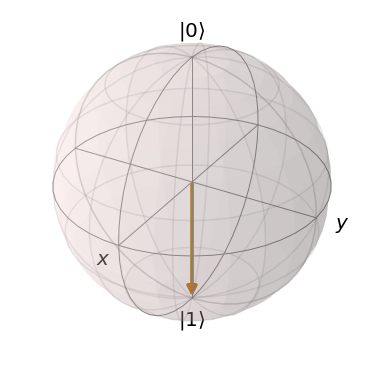

In [195]:
# Create a Bloch sphere
b = Bloch()
b.add_states(qubit_state)
b.add_states(target_state)
b.show()

## Plot the energy level population

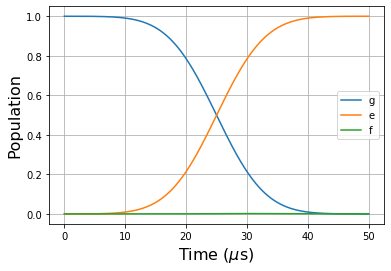

In [196]:
exp_g = expect(fock_dm(N,0),rho)
exp_e = expect(fock_dm(N,1),rho)
exp_f = expect(fock_dm(N,2),rho)

fig, ax = plt.subplots()
ax.plot(tlist, exp_g, label='g')
ax.plot(tlist, exp_e, label='e')
ax.plot(tlist, exp_f, label='f')
plt.xlabel('Time ($\mu$s)',fontsize=16)
plt.ylabel('Population',fontsize=16)

ax.legend()
ax.grid()

## Plot the shape of the pulse

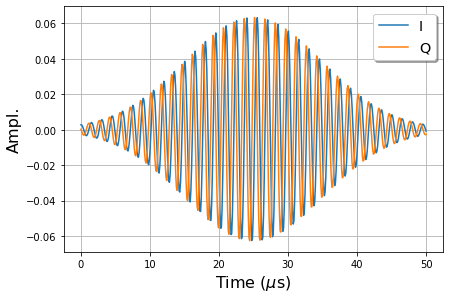

In [197]:
# in-phase component
I = H_drive_coeff_x(tlist, args)
# out of-phase component
Q = H_drive_coeff_y(tlist, args)

fig, ax = plt.subplots()
plt.tight_layout()
ax.plot(tlist, I, label='I')
ax.plot(tlist, Q, label='Q')

plt.xlabel('Time ($\mu$s)',fontsize=16)
plt.ylabel('Ampl.',fontsize=16)

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

ax.grid()

## Plot the state evolution on the Bloch sphere

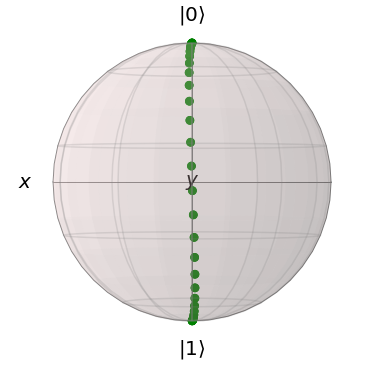

In [198]:
states = result.states
tlen = len(tlist) # number of time steps

# rotated transmon states 
rotated_states = [(1j*H_qubit*tlist[i]).expm()*states[i] for i in range(tlen)]

# project onto qubit subspace
qubit_states = [(basis(2,0)*basis(3,0).dag() + basis(2,1)*basis(3,1).dag())*rotated_states[i] for i in range(tlen)]

# Create a Bloch sphere
b = Bloch()
b.view = [0,0]
b.add_states(qubit_states[0::15],'point')
b.point_marker = ['o']
b.point_size = [60]
b.vector_color = ['g']
b.point_color = ['g']
b.show()

## Make Animation

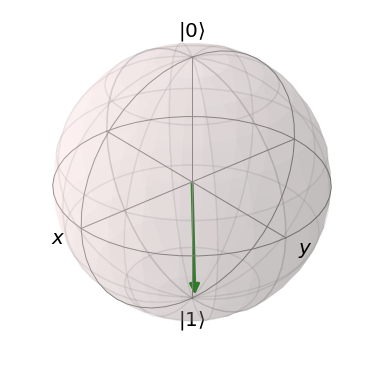

<Figure size 360x360 with 0 Axes>

In [132]:
fig = figure(figsize=(5, 5))
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)

def animate(i):
    sphere.clear()
    sphere.add_states(qubit_states[i])
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['g'] 
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(qubit_states)), init_func=init, repeat=False)
ani.save('pi-pulse.mp4', fps=100)

## References
- Propagator on QuTiP
    - http://qutip.org/docs/latest/guide/guide-visualization.html#quantum-process-tomography
- Average gate fidelity on QuTiP
    - http://qutip.org/docs/latest/modules/qutip/metrics.html#average_gate_fidelity

## Version

In [175]:
import qutip.ipynbtools
qutip.ipynbtools.version_table()

Software,Version
QuTiP,4.5.0.dev0+9f718cc3
Numpy,1.17.3
SciPy,1.3.2
matplotlib,3.1.2
Cython,0.29.14
Number of CPUs,6
BLAS Info,Generic
IPython,7.10.1
Python,"3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:19) [Clang 9.0.0 (tags/RELEASE_900/final)]"
OS,posix [darwin]


## Single qubit gate on two qubits

In [25]:
# energy levels
N = 3 # Qutrit

# Annihilation operator for the transmon
a = destroy(N)

# Qubit frequency (0->1) in GHz
omega = 2*np.pi * 5.708390

# Drive frequency in MHz
omega_drive = omega

# Self-Kerr coefficient (anharmonicity) in GHz
alpha = - 2*np.pi* 0.261081457

# Set rotating frame frequency (should be close to qubit frequencies for fast simulations)
rotating_frame = omega #2*np.pi*5.0

# Annihilation operators for the two qutrits
a2 = tensor(qeye(N), destroy(N))
a1 = tensor(destroy(N), qeye(N))

# Transmon Hamiltonian in rotating frame
H_qubit = (omega-rotating_frame) * a1.dag() * a1 + alpha / 2 * pow(a1.dag(),2) * pow(a1,2) + \
          (omega-rotating_frame) * a2.dag() * a2 + alpha / 2 * pow(a2.dag(),2) * pow(a2,2)

# Drive Hamiltonian (since we have drag pulses, we need both x and y drive)
H_drive_x_1 = a1.dag() + a1
H_drive_y_1 = 1j*(a1.dag() - a1)
H_drive_x_2 = a2.dag() + a2
H_drive_y_2 = 1j*(a2.dag() - a2)

# Gaussian width in ns
sigma = 10

# Gate time in ns
L = 50

def H_drive_coeff_x(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = q * (t-0.5*L) / sigma * E # dE/dt
    return I*np.cos(drive_freq * t) + Q*np.sin(drive_freq * t)

def H_drive_coeff_y(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = -q * (t-0.5*L) / sigma * E # dE/dt
    return Q*np.cos(drive_freq * t) + I*np.sin(drive_freq * t)

# total Hamiltonian
H = [H_qubit,
     [H_drive_x_1,H_drive_coeff_x],
     [H_drive_y_1,H_drive_coeff_y],
     [H_drive_x_2,H_drive_coeff_x],
     [H_drive_y_2,H_drive_coeff_y]
    ]

In [31]:
# initial state vacuum
psi = tensor(basis(N,0),basis(N,0))

# Schrödinger equation simulation
B = 0.06345380720748711
args = {'amp': B, 'qscale': 0.032, 'freq': (rotating_frame - omega_drive)}
result = mesolve(H, psi, tlist, [], [], args=args)
rho = result.states
final_state = rho[-1] # final state

In [35]:
# project onto qubit subspace
qubit_state = (tensor(basis(2,0),basis(2,0))*tensor(basis(3,0),basis(3,0)).dag() \
               + tensor(basis(2,1),basis(2,1))*tensor(basis(3,1),basis(3,1)).dag() \
               + tensor(basis(2,0),basis(2,1))*tensor(basis(3,0),basis(3,1)).dag() \
               + tensor(basis(2,1),basis(2,0))*tensor(basis(3,1),basis(3,0)).dag())*final_state

# normalize
qubit_state = qubit_state / qubit_state.norm()

# target state -|11⟩
target_state = tensor(rx(np.pi), rx(np.pi)) * tensor(basis(2,0),basis(2,0))

In [37]:
print(target_state)

# fidelity
fid = fidelity(qubit_state,target_state)
print('Fidelity =',round(fid,4))

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.]
 [ 0.]
 [ 0.]
 [-1.]]
Fidelity = 1.0


In [41]:
qubit_state

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 2.08387624e-05-1.65490172e-06j]
 [ 5.08982335e-05-7.00340484e-04j]
 [ 5.08982335e-05-7.00340484e-04j]
 [-9.96224516e-01+8.68085671e-02j]]

In [42]:
H_qubit

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -1.64042317  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -1.64042317
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -1.64042317  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -1.64042317  0.        ]
 [ 0.          0.          0.          0.          0.   